<a href="https://colab.research.google.com/github/songguan26/Bornean-Orangutan-Nest-/blob/main/Xception__orangutan_nest_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from collections import Counter

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.nasnet import NASNetLarge

from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from keras import Model, layers
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [ ]:
!nvidia-smi

Thu Jan 25 02:48:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
root_path = '/content/drive/MyDrive/orangutan_reg_system'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/content/drive/MyDrive/orangutan_reg_system/train'
seg_test_folders = '/content/drive/MyDrive/orangutan_reg_system/test'
seg_pred_folders = '/content/drive/MyDrive/orangutan_reg_system/pred'

In [ ]:
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history.history)

    # save to json:
    hist_json_file = model_name+'_history.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv:
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']


    epochs = range(len(acc))

    sns.lineplot(x=epochs, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs, y=val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()

def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    sns.lineplot(x=epochs, y=loss,label='Training Loss')
    sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.0)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance.
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=32, class_mode='categorical', target_size=(224, 224))

test_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_generator = test_datagen.flow_from_directory(seg_pred_folders, shuffle=True, batch_size=32, class_mode='categorical', target_size=(224, 224))

Found 133 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'nest': 0, 'no_nest': 1}
{0: 'nest', 1: 'no_nest'}


83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 0.3930 - accuracy: 0.9023
Epoch 1: val_accuracy improved from -inf to 0.97561, saving model to Xception_16_-saved-model-01-loss-0.39.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 68s 12s/step - loss: 0.3930 - accuracy: 0.9023 - val_loss: 0.3768 - val_accuracy: 0.9756
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9925
Epoch 2: val_accuracy did not improve from 0.97561
5/5 [==============================] - 13s 3s/step - loss: 0.0398 - accuracy: 0.9925 - val_loss: 0.4912 - val_accuracy: 0.9756
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 3.0743e-07 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.97561 to 1.00000, saving model to Xception_16_-saved-model-03-loss-0.00.hdf5
5/5 [==============================] - 15s 4s/step - loss: 3.0743e-07 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 4/5
5/5 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
5/5 [==============================] - 14s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.6168e-08 - va

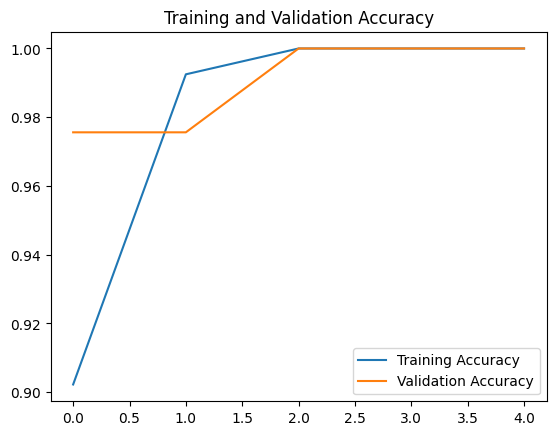

<Figure size 640x480 with 0 Axes>

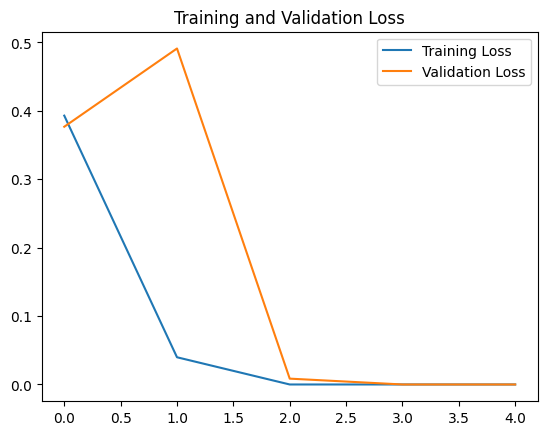

<Figure size 640x480 with 0 Axes>

In [ ]:
#strategy one ->adamlr0.001
#freezing convolutional layers; replacing classification layers
Xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layers in Xception_model.layers:
            layers.trainable=False

last_output = Xception_model.layers[-1].output
Xception_x = Flatten()(last_output)
Xception_x = Dense(128, activation = 'relu')(Xception_x)
Xception_x = Dropout(0.3)(Xception_x)
Xception_x = Dense(2, activation = 'softmax')(Xception_x)
Xception_final_model = Model(Xception_model.input, Xception_x)
Xception_final_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

# Xception
Xception_filepath = 'Xception_16_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
Xception_checkpoint = tf.keras.callbacks.ModelCheckpoint(Xception_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
Xception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
Xception_history = Xception_final_model.fit(train_generator, epochs = 5, batch_size=32, validation_data = validation_generator,callbacks=[Xception_checkpoint,Xception_early_stopping],verbose=1)

do_history_stuff(Xception_history, 'Xception_model')

1/1 [==============================] - 0s 26ms/step
Model Accuracy 1.0
              precision    recall  f1-score   support

        Nest       1.00      1.00      1.00         7
      Nonest       1.00      1.00      1.00        20

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



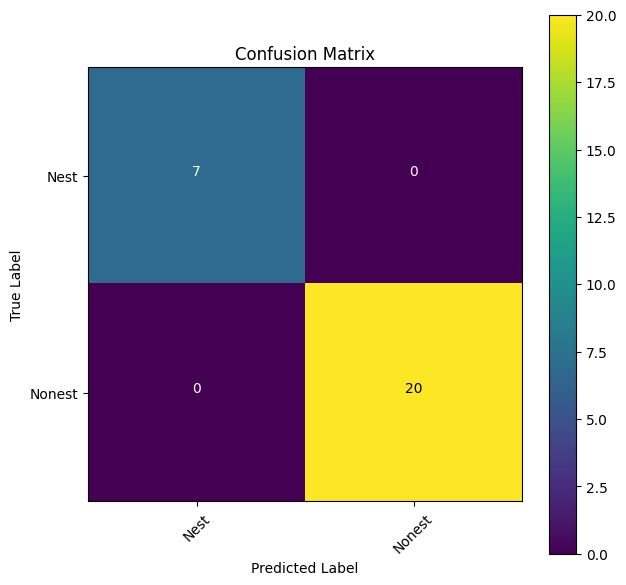

In [ ]:
#pred

InceptionV3_best_model = InceptionV3_final_model

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
InceptionV3_pred = []
for folder in os.listdir(seg_pred_folders):

    test_image_ids = os.listdir(os.path.join(seg_pred_folders,folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:

        path = os.path.join(seg_pred_folders,folder,image_id)

        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(224,224))
        img_normalized = img/255

        #InceptionV3
        InceptionV3_image_prediction = np.argmax(InceptionV3_best_model.predict(np.array([img_normalized])))
        InceptionV3_pred.append(InceptionV3_image_prediction)

from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):

    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))

# RInceptionV3 model classification report
clf_report(true_value, InceptionV3_pred)